In [1]:
import pandas as pd
import os
from prophet import Prophet
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\82107\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 데이터 불러오기

In [2]:
os.chdir('C:\\Users\\82107\\OneDrive\\바탕 화면\\KMU\\공부\\TP\\prophet\\simulation')

In [3]:
data = pd.read_csv('normal_simulation_set.csv', index_col=0) 

In [4]:
# datetime 형태로 변경
data['update_time'] = pd.to_datetime(data['update_time'])

In [5]:
data.shape

(1350, 2701)

In [6]:
data.head()

,update_time,heart_rate1,event1,heart_rate2,event2,heart_rate3,event3,heart_rate4,event4,heart_rate5,...,heart_rate1346,event1346,heart_rate1347,event1347,heart_rate1348,event1348,heart_rate1349,event1349,heart_rate1350,event1350
0,2023-10-01 00:00:00,96,0,75,0,97,0,80,0,84,...,77,0,88,0,69,0,78,0,79,0
1,2023-10-01 00:10:00,73,0,79,0,84,0,84,0,76,...,86,0,86,0,84,0,71,0,65,0
2,2023-10-01 00:20:00,74,0,58,1,80,0,70,0,104,...,78,0,77,0,93,0,99,0,70,0
3,2023-10-01 00:30:00,69,0,96,0,61,0,86,0,77,...,72,0,80,0,75,0,74,0,78,0
4,2023-10-01 00:40:00,88,0,62,0,77,0,75,0,81,...,95,0,66,0,90,0,89,0,75,0


In [7]:
# column 명 바꾸기
df = data[['update_time', 'heart_rate1', 'event1']]
df.rename(columns = {'update_time' : 'ds', 'heart_rate1' : 'y'}, inplace = True)

In [8]:
# train 데이터와 test 데이터 나누기
train1 = df[:1008]
test = df[1008:]

In [9]:
print(train1.shape)
print(test.shape)

(1008, 3)
(342, 3)


In [10]:
# event 비율
print(train1['event1'].value_counts(normalize=True))
print(test['event1'].value_counts(normalize=True))

0    0.959325
1    0.040675
Name: event1, dtype: float64
0    0.967836
1    0.032164
Name: event1, dtype: float64


In [11]:
# 필요한 column만 추출
train = train1[['ds', 'y']]
# test1 -> predict시키기 위해 test의 ds만 추출해서 test1 데이터 새로 생성함
test1 = test[['ds']]
test1.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [12]:
test1.head()

,ds
0,2023-10-08 00:00:00
1,2023-10-08 00:10:00
2,2023-10-08 00:20:00
3,2023-10-08 00:30:00
4,2023-10-08 00:40:00


### Prophet

In [13]:
np.random.seed(1)
model  = Prophet(interval_width = 0.95)
# interval_width : width of the uncertainty intervals provided for the forecast.

model.fit(train)

00:23:41 - cmdstanpy - INFO - Chain [1] start processing
00:23:41 - cmdstanpy - INFO - Chain [1] done processing


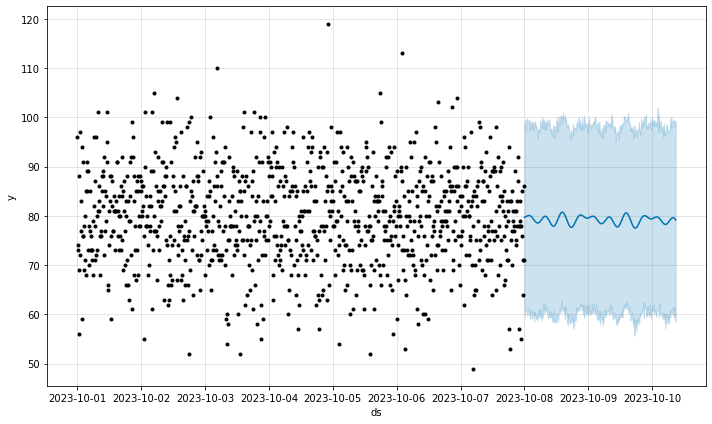

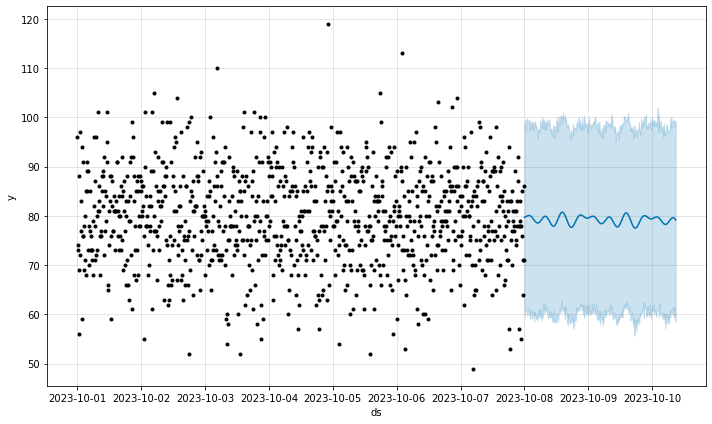

In [14]:
forecast = model.predict(test1)

model.plot(forecast)

In [15]:
performance = pd.merge(test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on = 'ds')

In [16]:
performance['pred_y'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
performance['pred_y'].value_counts()

0    324
1     18
Name: pred_y, dtype: int64

In [17]:
# 이상치 정의
anomalies = performance[performance['pred_y']==1].sort_values(by = 'ds')

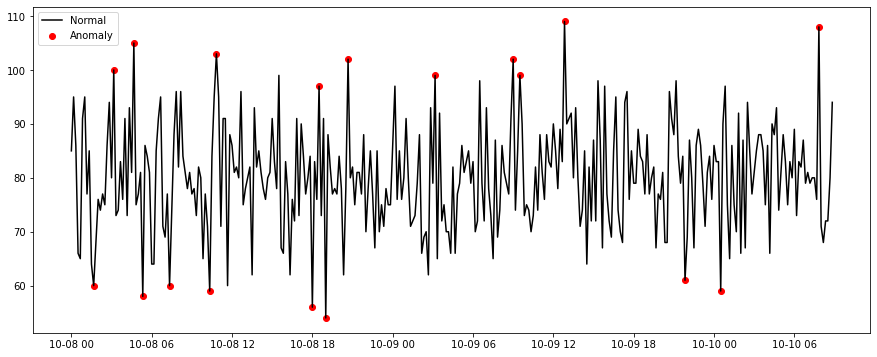

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
a = performance.loc[performance['pred_y'] == 1] # anomaly로 판단
ax.plot(performance['ds'], performance['y'], color='black', label = 'Normal')
ax.scatter(a['ds'], a['y'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

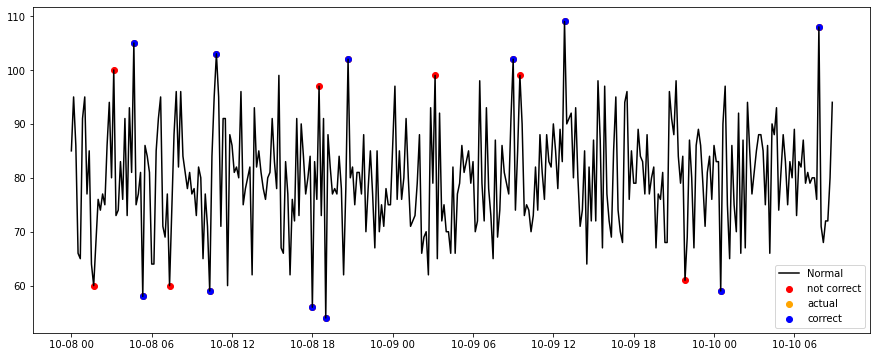

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
a = performance.loc[performance['pred_y'] == 1] # anomaly로 판단
b = performance.loc[performance['event1'] == 1]
c = performance.loc[(performance['event1'] == 1) & (performance['pred_y'] == 1)]
ax.plot(performance['ds'], performance['y'], color='black', label = 'Normal')
ax.scatter(a['ds'], a['y'], color ='red', label = 'not correct')
ax.scatter(b['ds'], b['y'], color = 'orange', label = 'actual')
ax.scatter(c['ds'], c['y'], color = 'blue', label = 'correct')
plt.legend()
plt.show()

In [20]:
# 최종 데이터
pred = performance[['ds', 'y', 'event1', 'pred_y']]
pred.rename(columns = {'ds' : 'update_time', 'y' : 'heart_rate1'}, inplace = True)
pred

,update_time,heart_rate1,event1,pred_y
0,2023-10-08 00:00:00,85,0,0
1,2023-10-08 00:10:00,95,0,0
2,2023-10-08 00:20:00,86,0,0
3,2023-10-08 00:30:00,66,0,0
4,2023-10-08 00:40:00,65,0,0
...,...,...,...,...
337,2023-10-10 08:10:00,68,0,0
338,2023-10-10 08:20:00,72,0,0
339,2023-10-10 08:30:00,72,0,0
340,2023-10-10 08:40:00,80,0,0


In [21]:
print(pred['event1'].value_counts())
print(pred['pred_y'].value_counts())

0    331
1     11
Name: event1, dtype: int64
0    324
1     18
Name: pred_y, dtype: int64
